<a href="https://colab.research.google.com/github/szymonkulpinski/colab_notebooks/blob/main/teams_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check if GPU is in use
If this command fails: click in the upper-right corner of this window 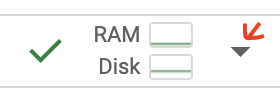
 and select `Change runtime type` and then select `T4 GPU`







In [2]:
!nvidia-smi

Mon Feb  3 21:05:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install all dependencies

In [3]:
!pip install -q roboflow supervision umap-learn tqdm transformers adjustText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


### Make all the relevant imports

In [4]:
import os
import time
import pickle
import umap
import torch
import cv2
import warnings

import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

from tqdm import tqdm
from roboflow import Roboflow
from google.colab import userdata
from pathlib import Path
from sklearn.cluster import KMeans
from more_itertools import chunked
from typing import Tuple
from transformers import AutoFeatureExtractor, ResNetModel, AutoProcessor, SiglipVisionModel,CLIPProcessor, CLIPVisionModel

### Define constants and settings


In [5]:
if 'google.colab' in str(get_ipython()):
  HOME = "/content"
else:
  HOME = os.getcwd()

# In the used dataset all of the images have the resolution of 1920x1080px
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

# Settings
NUM_ITERATIONS = 50 # set to 1 if you only want to evaluate once, for evalutation used 50
BATCH_SIZE_ARRAY = [32]
FOLDER_DIR = "/content/drive/MyDrive/0_teams-clustering" # where in google colab the experiments results should be saved
RUN_EXPERIMENTS = False # if set to true experiments will be run, if to false it will only read saved results

versions_to_test = [
  "google/siglip-base-patch16-512",
  "google/siglip-base-patch16-384",
  "google/siglip-base-patch16-256",
  "google/siglip-base-patch16-224",
  "google/siglip-large-patch16-256",
  "google/siglip-large-patch16-384",
  "google/siglip-so400m-patch14-384",
  "google/siglip-so400m-patch14-224",
  "google/siglip-so400m-patch16-256-i18n",
  "microsoft/resnet-18",
  "microsoft/resnet-26",
  "microsoft/resnet-34",
  "microsoft/resnet-50",
  "microsoft/resnet-101",
  "microsoft/resnet-152",
  'openai/clip-vit-base-patch16',
  'openai/clip-vit-base-patch32',
  'openai/clip-vit-large-patch14',
  'openai/clip-vit-large-patch14-336',
]

# Ablation study settings
DO_ABLATION_STUDY = False
# BATCH_SIZE_ARRAY = [1,2,8,32] # values used in the ablation study


### Mount your google drive to google colab be able to save the results

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
Path(FOLDER_DIR).mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get the dataset and adjust the folder structure
If you haven't added your `ROBOFLOW_API_KEY` to your secrets in Google Colab, this code snippet will fail. Follow the instructions in this [Roboflow Notebook](https://colab.research.google.com/github/roboflow/sports/blob/main/examples/soccer/notebooks/train_player_detector.ipynb#scrollTo=BSd93ZJzZZKt) to add it.


In [7]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("szymon-kulpinski").project("football-players-clustering")
version = project.version(6)
dataset = version.download("yolov8") # use the format as the easier to work with then e.g. COCO
print(dataset.location)

!mv {dataset.location}/train/images/* {dataset.location}/train/
!mv {dataset.location}/train/labels/* {dataset.location}/train/
!rm -rdf {dataset.location}/train/images
!rm -rdf {dataset.location}/train/labels

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-clustering-6 in yolov8:: 100%|██████████| 106/106 [00:00<00:00, 2258.48it/s]


/content/datasets/football-players-clustering-6


### Load the dataset as Supervision Detections

In [8]:
def convert_yolov8bbox_2_xyxy(xcycwh: np.ndarray) -> np.ndarray:
  # center_x center_y width height from https://roboflow.com/formats/yolov8-pytorch-txt.
  xcycwh[:,0] = xcycwh[:,0] * IMAGE_WIDTH
  xcycwh[:,1] = xcycwh[:,1] * IMAGE_HEIGHT
  xcycwh[:,2] = xcycwh[:,2] * IMAGE_WIDTH
  xcycwh[:,3] = xcycwh[:,3] * IMAGE_HEIGHT
  return sv.xcycwh_to_xyxy(xcycwh)

In [9]:
folder_path = Path(dataset.location)/ "train"
jpg_files = list(folder_path.glob('**/*.jpg'))
txt_files = [file.with_suffix('.txt') for file in jpg_files]

detections_list = []
for file in txt_files:
  data = np.loadtxt(str(file))
  class_id = data[:,0].astype(np.int32)
  xyxy = convert_yolov8bbox_2_xyxy(data[:,1:])
  detections_list.append(sv.Detections(xyxy=xyxy, class_id=class_id))
print(detections_list[0])

Detections(xyxy=array([[1236.  ,  464.  , 1252.  ,  504.  ],
       [1271.  ,  427.  , 1287.  ,  469.  ],
       [ 871.  ,  409.  ,  888.  ,  450.  ],
       [1249.  ,  460.  , 1265.  ,  507.  ],
       [ 887.  ,  485.  ,  912.  ,  529.  ],
       [ 901.  ,  412.  ,  917.  ,  451.  ],
       [ 972.  ,  450.  ,  998.  ,  492.  ],
       [1352.  ,  433.  , 1373.  ,  478.  ],
       [ 590.09,  405.  ,  613.09,  444.  ],
       [ 709.  ,  549.  ,  732.  ,  604.  ],
       [1175.  ,  497.  , 1194.  ,  546.  ],
       [ 550.  ,  447.  ,  567.  ,  490.  ],
       [1023.  ,  523.  , 1042.  ,  574.  ],
       [1493.  ,  503.  , 1519.  ,  557.  ],
       [ 554.  ,  512.  ,  576.  ,  565.  ],
       [ 949.  ,  465.  ,  980.  ,  506.  ],
       [1305.  ,  665.  , 1325.  ,  726.  ],
       [1247.  ,  593.  , 1268.  ,  650.  ],
       [1433.  ,  527.  , 1455.  ,  574.  ],
       [1424.  ,  726.  , 1454.  ,  796.  ]]), mask=None, confidence=None, class_id=array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,

### Visualise the detections on the image, double check if the conversion was successful


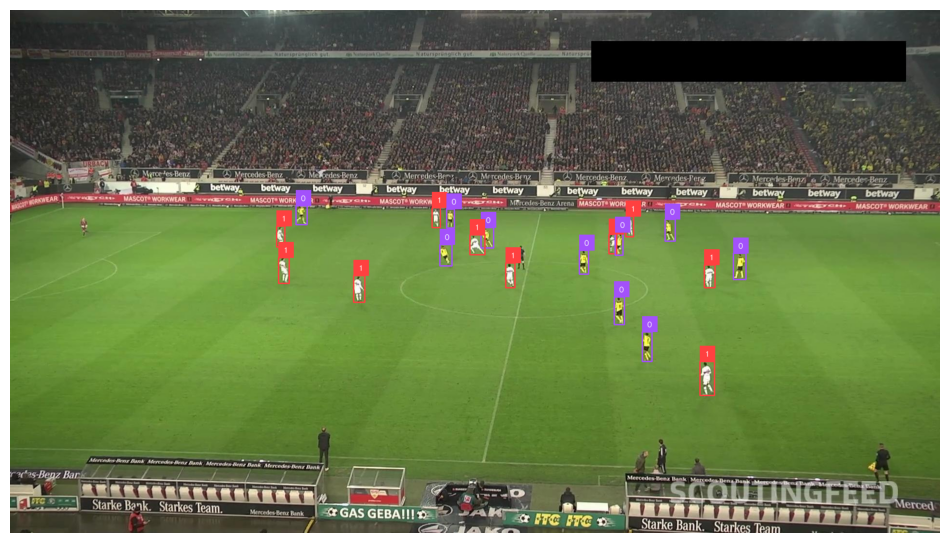

In [10]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
image= cv2.imread(str(jpg_files[0]))
detections = detections_list[0]
annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)
sv.plot_image(image=annotated_image, size=(12, 12))

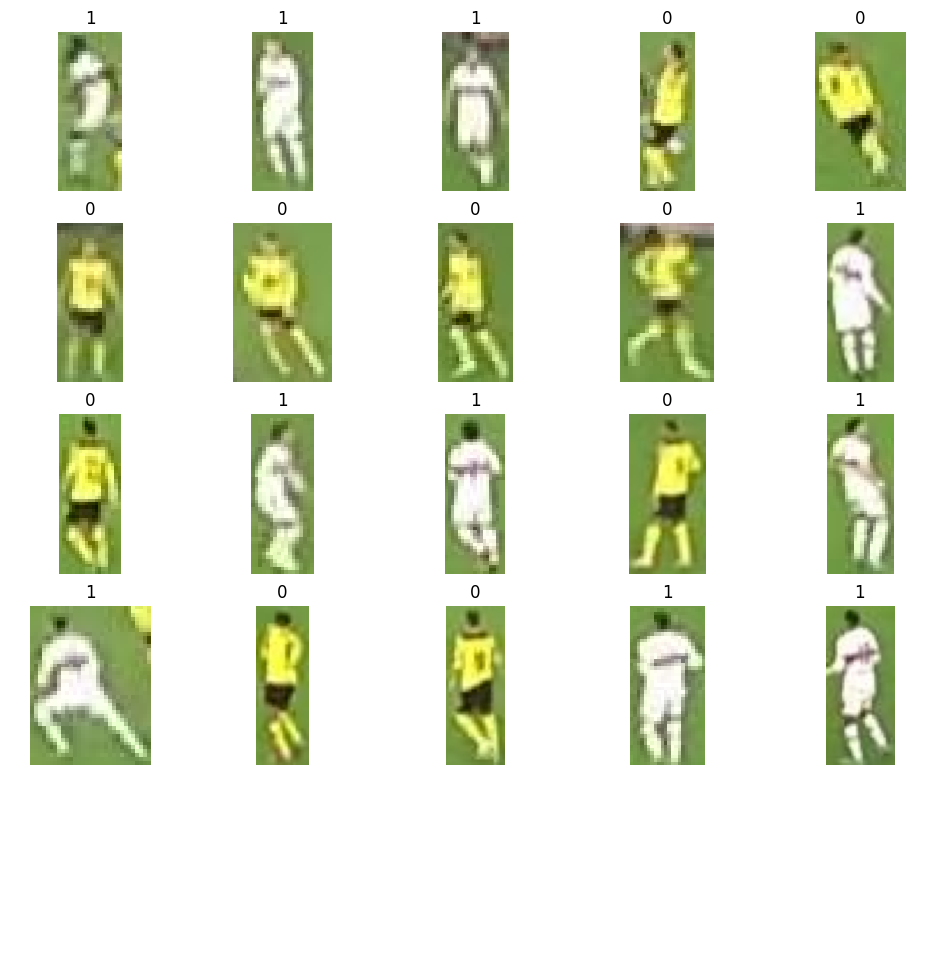

In [11]:
players_crops = [sv.crop_image(image, xyxy) for xyxy in detections.xyxy]
sv.plot_images_grid(players_crops, grid_size=(5,5), titles = [f"{i}" for i in detections_list[0].class_id])

### Define helper methods and class

In [12]:
class Experiment:
  def __init__(self, model_path: str):
    self.model_path = model_path
    self.model = None
    self.processor = None
    self.results_list = []
    self.clusters_list = []
    self.execution_time_list = []
    self.total_execution_time_list = []
    if "clip" in model_path:
      self.model_type = "CLIP"
    elif "siglip" in model_path:
      self.model_type = "SIGLIP"
    elif "resnet" in model_path:
      self.model_type = "RESNET"
    else:
      raise ValueError("Unknown model type")


  def init_model_n_processor(self):
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    if self.model_type == "CLIP":
      self.model = CLIPVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path)
    elif self.model_type == "SIGLIP":
      self.model = SiglipVisionModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoProcessor.from_pretrained(self.model_path)
    elif self.model_type == "RESNET":
      self.model = ResNetModel.from_pretrained(self.model_path).to(DEVICE)
      self.processor = AutoFeatureExtractor.from_pretrained(self.model_path)


  def forward(self, batch: np.ndarray) -> np.ndarray:
    with torch.no_grad():
      inputs = self.processor(images=batch, return_tensors="pt").to(DEVICE)
      outputs = self.model(**inputs)
      if self.model_type == "RESNET":
        embeddings = torch.mean(outputs.last_hidden_state, dim=[2, 3]).cpu().numpy()
      else:
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
      return embeddings


  def clean_up(self):
    self.model = None
    self.processor = None


In [13]:
def get_best_results_n_clusters(b_clusters: np.ndarray, b_class_id: np.ndarray)-> Tuple[np.ndarray, np.ndarray]:
  '''
    Compares predicted clusters (b_clusters) with ground truth class IDs (b_class_id)
    and potentially inverts the clusters to achieve the best possible accuracy.

    Setting all predictions to 1 or 0 will have at least a 50% success rate,
    so the classifier cannot perform worse than that.
    The assignment of cluster 0 and cluster 1 is arbitrary.
    Inverting the results to the "best result" corresponds to actual classification results.

    Args:
        b_clusters (np.ndarray): Predicted cluster assignments (0 or 1).
        b_class_id (np.ndarray): Ground truth class IDs (0 or 1).

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - A boolean array indicating whether each prediction is correct after potential inversion.
            - The cluster assignments (0 or 1) after potential inversion.
  '''

  result = b_clusters == b_class_id
  if result.sum() < len(clusters)/2:
    b_clusters = ~b_clusters
    result = b_clusters == b_class_id
  return result, b_clusters.astype(np.int32)

def save_results_to_google_drive(experiments_list: list, batch_size: int, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  with open(filename, 'wb') as f:
    pickle.dump(experiments_list, f)

def load_results_from_google_drive(batch_size: list, is_iteration=False):
  if is_iteration:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch32_it" + str(batch_size) + ".pkl"))
  else:
    filename = str(Path(FOLDER_DIR ) / ("experiments_list_batch" + str(batch_size) + ".pkl"))
  loaded_experiment_list = None
  with open(filename, 'rb') as f:
    loaded_experiment_list = pickle.load(f)
  return loaded_experiment_list


### Init methods

In [14]:
Umap_reducer = umap.UMAP(n_components=3)
KMeans_model = KMeans(n_clusters=2)

experiments_list = [Experiment(model_path) for model_path in versions_to_test]
print(len(experiments_list))

19


### Run the evaluation and save the results to your google drive for future evaluation

In [15]:
if RUN_EXPERIMENTS:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for iteration in range(NUM_ITERATIONS):
    print("Iteration: ", iteration)
    experiments_list = [Experiment(model_path) for model_path in versions_to_test] # prevent appending into infinity, create objects anew
    for batch_size in BATCH_SIZE_ARRAY:
      for k, exp in enumerate(experiments_list):
        print("Model:", exp.model_path)
        print("Batch size:", batch_size)
        exp.init_model_n_processor()
        for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
            image = cv2.imread(str(image_path))
            players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
            pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
            batches = chunked(pillow_crops, batch_size)

            data = []
            start_time = time.perf_counter()
            for batch in batches:
              data.append(exp.forward(batch))
            end_time = time.perf_counter()
            exp.execution_time_list.append(end_time - start_time)

            data = np.concatenate(data)
            projections = Umap_reducer.fit_transform(data)
            clusters = np.array(KMeans_model.fit_predict(projections))

            total_time = time.perf_counter()
            exp.total_execution_time_list.append(total_time - start_time)

            result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
            exp.results_list.append(result.sum() / len(clusters))
            exp.clusters_list.append(clusters)
        exp.clean_up()
        experiments_list[k] = exp

        print("Mean accuracy: ", np.mean(exp.results_list))
        print("Mean execution time: ", np.mean(exp.execution_time_list))
        print("Mean FPS: ", 1/np.mean(exp.execution_time_list))
        print("Double check exp.results_list length: ", len(exp.results_list))
        print(exp.results_list)
        print("\n")

      save_results_to_google_drive(experiments_list, iteration, is_iteration=True)

#### Visualise one of the results for some or all of the images for the last experiment


In [16]:
def display_for_id(id: int, exp: Experiment):
  image = cv2.imread(str(jpg_files[id]))
  players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[id].xyxy]
  print("Score: ", exp.results_list[id])
  sv.plot_images_grid(players_crops, grid_size=(5,5),
                      titles = [f"gt:{i} pred:{j}" for i,j in zip(detections_list[id].class_id,exp.clusters_list[id])])

try:
  # display_for_id(np.argmax(exp.results_list), exp)
  display_for_id(np.argmin(exp.results_list), exp)
  # for id in range(len(exp.results_list)):
  #   display_for_id(id, exp)
except NameError:
  print("No experiment was run therfore the plot won't work")


No experiment was run therfore the plot won't work


# Individual cumulativ evaluation plots


In [38]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS = 2
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

# Settings
num_images = len(all_experiments_for_all_iterations[0][0].results_list)
rows = NUM_ITERATIONS * num_images

accuracy_array = np.zeros((rows, len(versions_to_test)))
exec_time_array = np.zeros((rows, len(versions_to_test)))
total_exec_time_array = np.zeros((rows, len(versions_to_test)))
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    accuracy_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.results_list
    exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.execution_time_list
    total_exec_time_array[i_batch*num_images:(i_batch+1)*num_images,i_exp] = current_exp.total_execution_time_list
  model_name_list.append(current_exp.model_path)


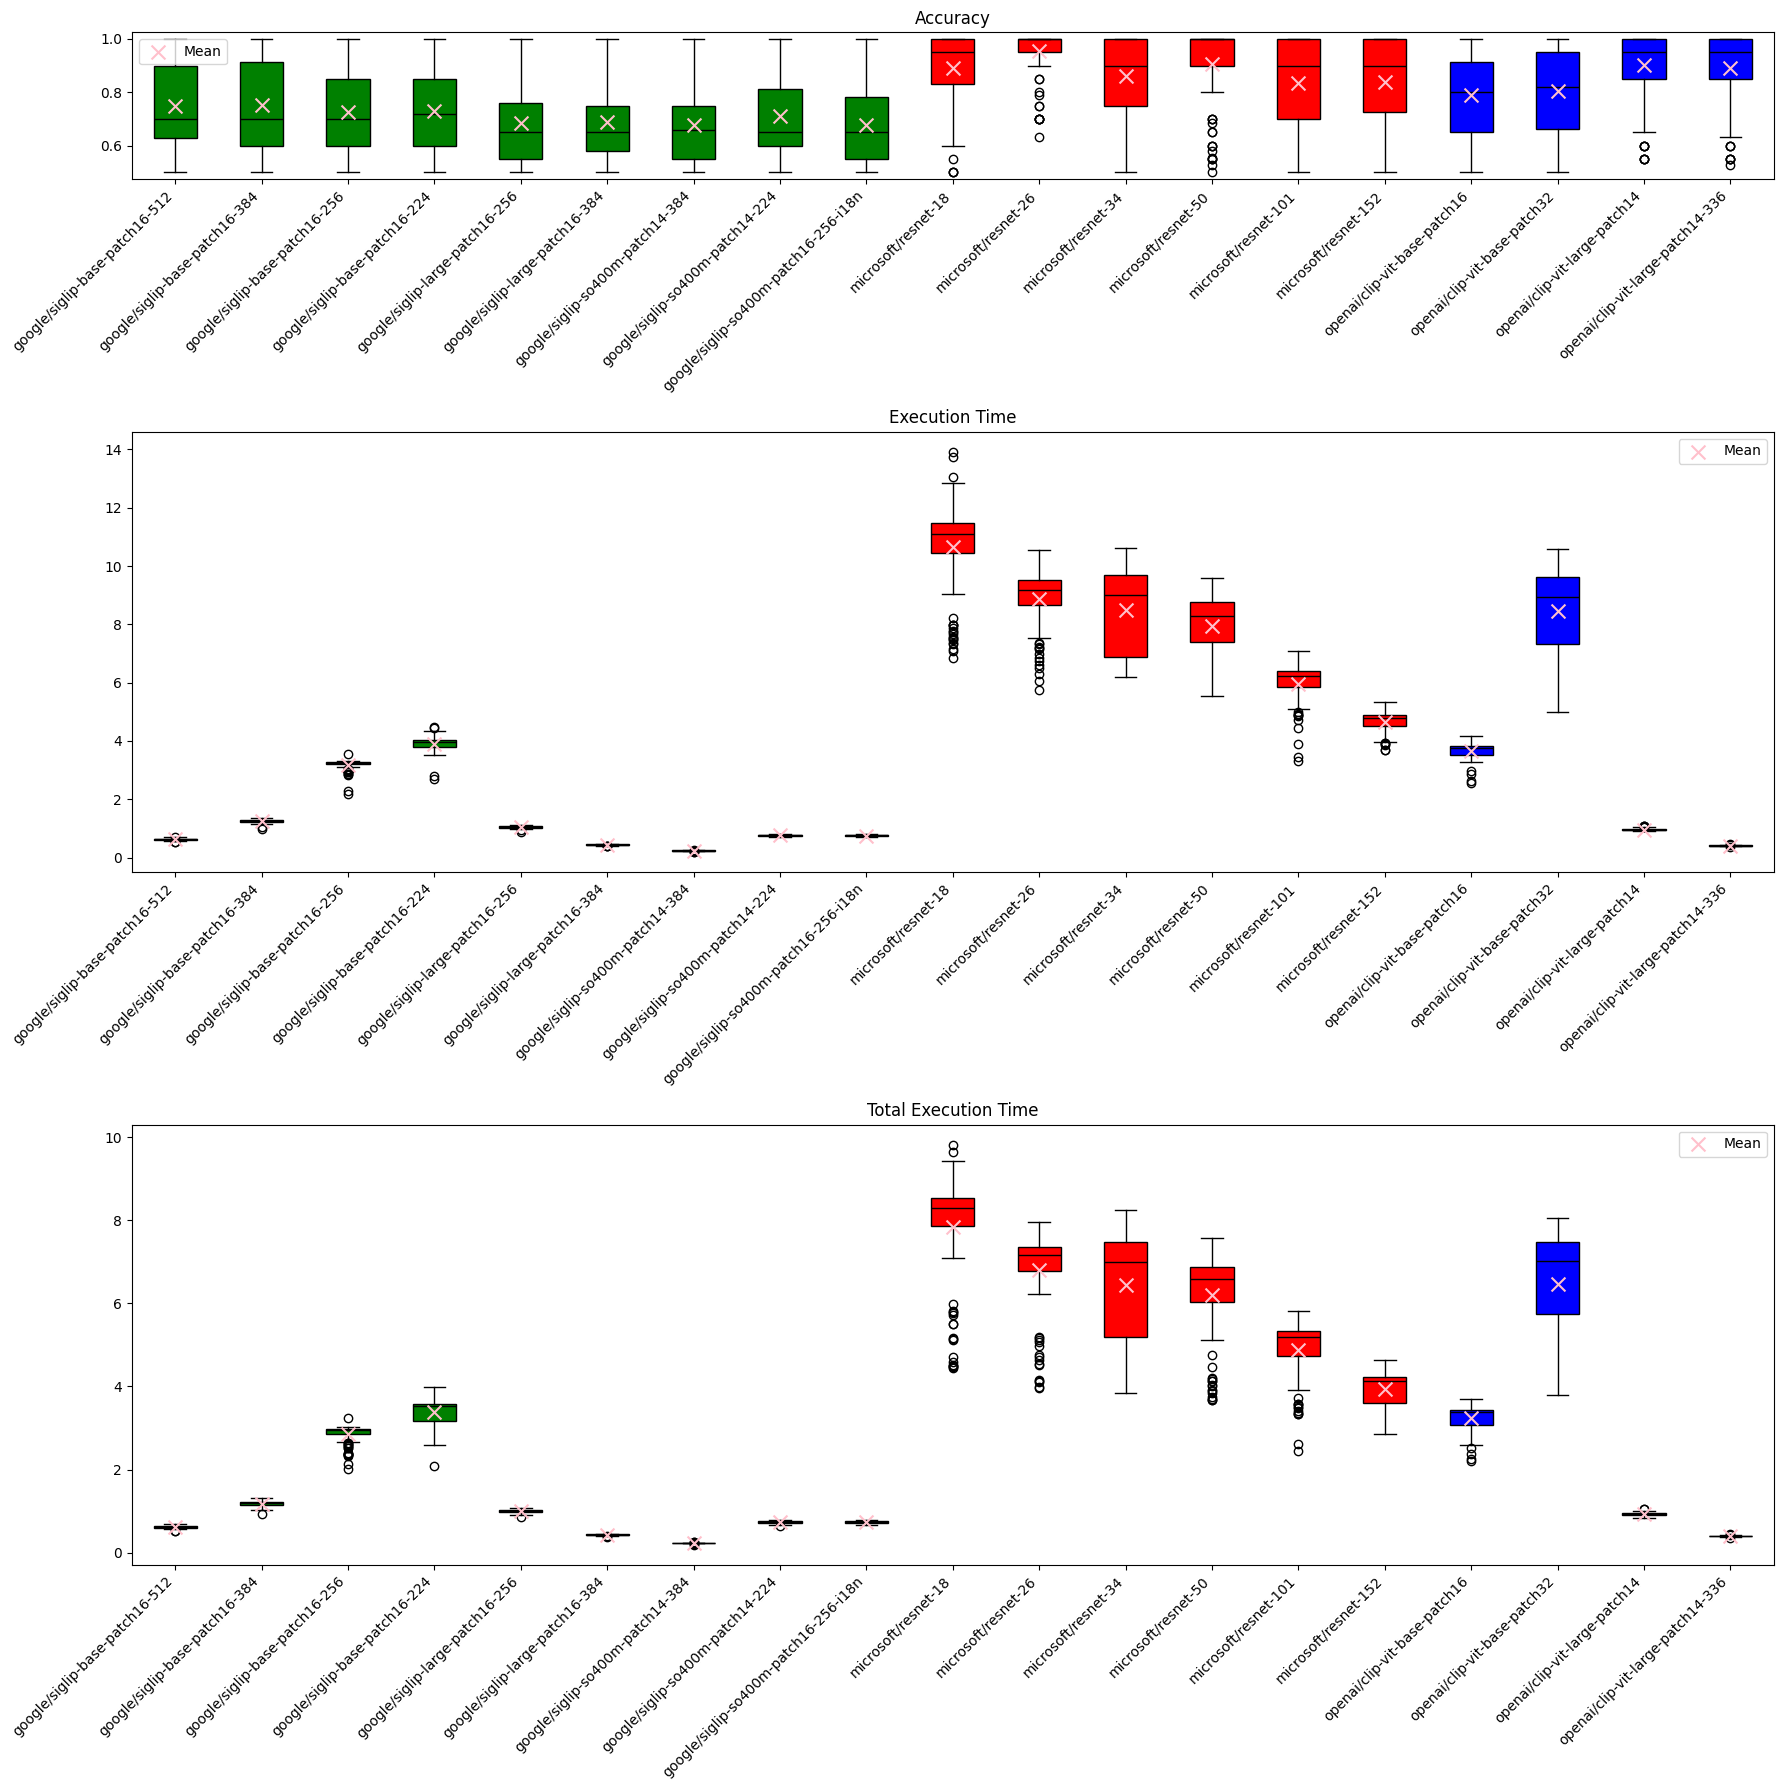

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure and axes for the boxplots
# fig, axes = plt.subplots(3, 1, figsize=(18, 18))  # 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 3, 3]})  # Adjust height ratios


# Method names and corresponding colors
method_names = model_name_list
method_types = ['siglip' if 'siglip' in name else 'resnet' if 'resnet' in name else 'clip' for name in method_names]
colors = ['g' if 'siglip' in name else 'r' if 'resnet' in name else 'b' for name in method_names]

# --- Accuracy ---
bp1 = axes[0].boxplot(accuracy_array, patch_artist=True, medianprops=dict(color="black")) # patch_artist=True to be able to color the boxes
axes[0].set_title('Accuracy')
axes[0].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp1['boxes'], colors):
    box.set_facecolor(color)

# --- Execution Time ---
bp2 = axes[1].boxplot(1/exec_time_array, patch_artist=True, medianprops=dict(color="black"))
axes[1].set_title('Execution Time')
axes[1].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp2['boxes'], colors):
    box.set_facecolor(color)

# --- Total Execution Time ---
bp3 = axes[2].boxplot(1/total_exec_time_array, patch_artist=True, medianprops=dict(color="black"))
axes[2].set_title('Total Execution Time')
axes[2].set_xticklabels(method_names, rotation=45, ha='right')
for box, color in zip(bp3['boxes'], colors):
    box.set_facecolor(color)


# Calculate and plot average values for Accuracy
means_acc = np.mean(accuracy_array, axis=0)
axes[0].scatter(np.arange(1, len(method_names) + 1), means_acc, marker='x', color='pink', s=100, label='Mean', zorder=10)
# Calculate and plot average values for Execution Time
means_exec = np.mean(1/exec_time_array, axis=0)
axes[1].scatter(np.arange(1, len(method_names) + 1), means_exec, marker='x', color='pink', s=100, label='Mean', zorder=10)
# Calculate and plot average values for Total Execution Time
means_total_exec = np.mean(1/total_exec_time_array, axis=0)
axes[2].scatter(np.arange(1, len(method_names) + 1), means_total_exec, marker='x', color='pink', s=100, label='Mean', zorder=10)

for ax in axes:
  ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


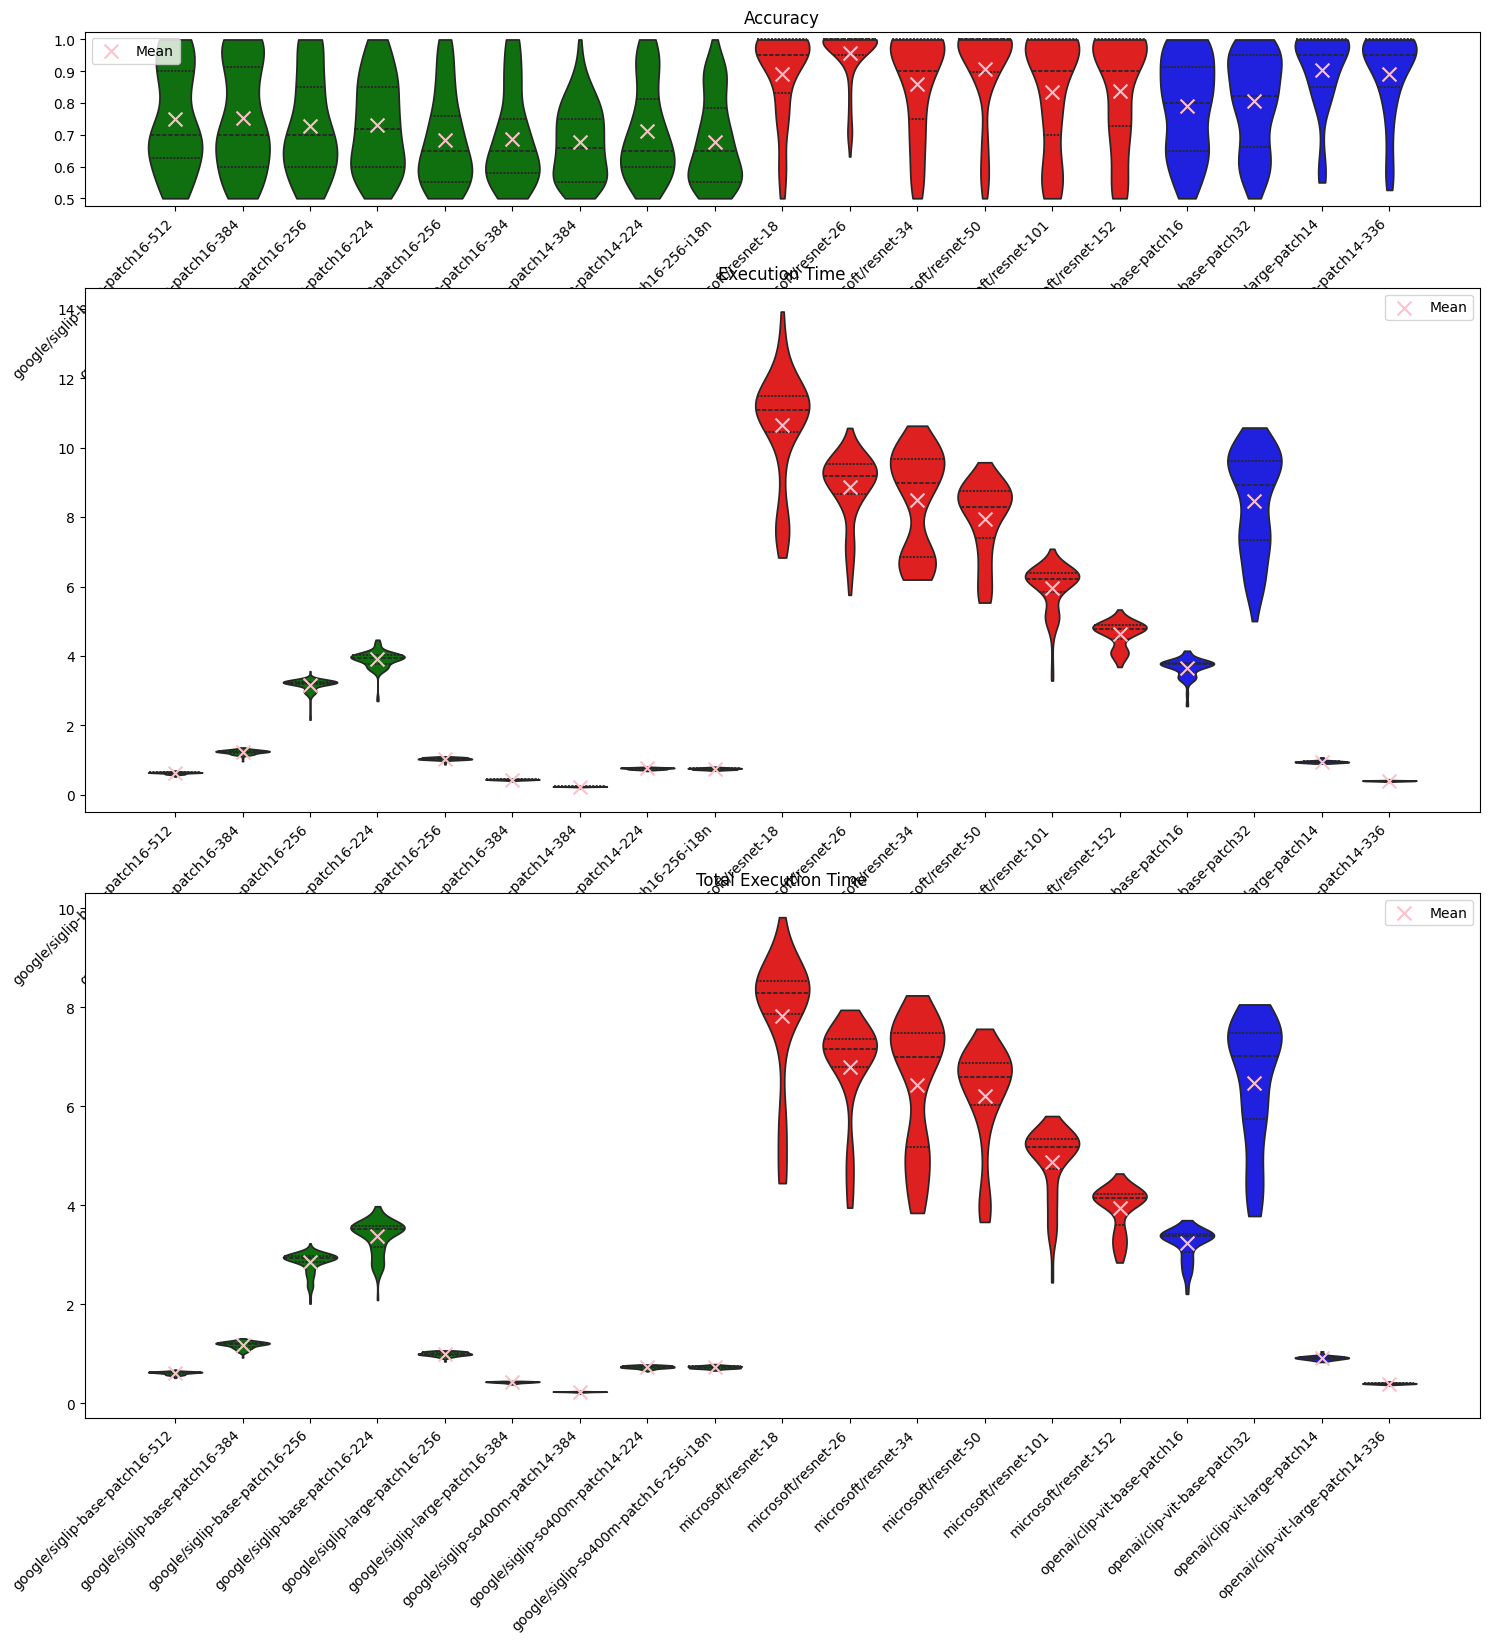

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure and axes for the plots
fig, axes = plt.subplots(3, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 3, 3]})

# Method names and corresponding colors
method_names = model_name_list
method_types = ['siglip' if 'siglip' in name else 'resnet' if 'resnet' in name else 'clip' for name in method_names]
colors = ['g' if 'siglip' in name else 'r' if 'resnet' in name else 'b' for name in method_names]

# --- Accuracy ---
# Boxplot with jitter
# sns.boxplot(data=accuracy_array, ax=axes[0], palette=colors, showfliers=False)  # showfliers=False to hide outliers
# sns.stripplot(data=accuracy_array, ax=axes[0], jitter=True, color='black', size=3, alpha=0.5)  # Add jitter points
# Violin plot
sns.violinplot(data=accuracy_array, ax=axes[0], palette=colors, inner="quartile", cut=0) # showfliers=False to hide outliers
# sns.violinplot(data=accuracy_array, ax=axes[0], palette=colors, cut=0) # showfliers=False to hide outliers

axes[0].set_title('Accuracy')
axes[0].set_xticklabels(method_names, rotation=45, ha='right')


# --- Execution Time ---
# Boxplot with jitter
# sns.boxplot(data=1/exec_time_array, ax=axes[1], palette=colors, showfliers=False)
# sns.stripplot(data=1/exec_time_array, ax=axes[1], jitter=True, color='black', size=3, alpha=0.5)
# Violin plot
sns.violinplot(data=1/exec_time_array, ax=axes[1], palette=colors, inner="quartile", cut=0) # showfliers=False to hide outliers

axes[1].set_title('Execution Time')
axes[1].set_xticklabels(method_names, rotation=45, ha='right')


# --- Total Execution Time ---
# Boxplot with jitter
# sns.boxplot(data=1/total_exec_time_array, ax=axes[2], palette=colors, showfliers=False)
# sns.stripplot(data=1/total_exec_time_array, ax=axes[2], jitter=True, color='black', size=3, alpha=0.5)
# Violin plot
sns.violinplot(data=1/total_exec_time_array, ax=axes[2], palette=colors, inner="quartile", cut=0) # showfliers=False to hide outliers


axes[2].set_title('Total Execution Time')
axes[2].set_xticklabels(method_names, rotation=45, ha='right')

# Calculate and plot average values for Accuracy
means_acc = np.mean(accuracy_array, axis=0)
axes[0].scatter(np.arange(0, len(method_names)), means_acc, marker='x', color='pink', s=100, label='Mean', zorder=10)
# Calculate and plot average values for Execution Time
means_exec = np.mean(1/exec_time_array, axis=0)
axes[1].scatter(np.arange(0, len(method_names)), means_exec, marker='x', color='pink', s=100, label='Mean', zorder=10)
# Calculate and plot average values for Total Execution Time
means_total_exec = np.mean(1/total_exec_time_array, axis=0)
axes[2].scatter(np.arange(0, len(method_names)), means_total_exec, marker='x', color='pink', s=100, label='Mean', zorder=10)

for ax in axes:
  ax.legend()

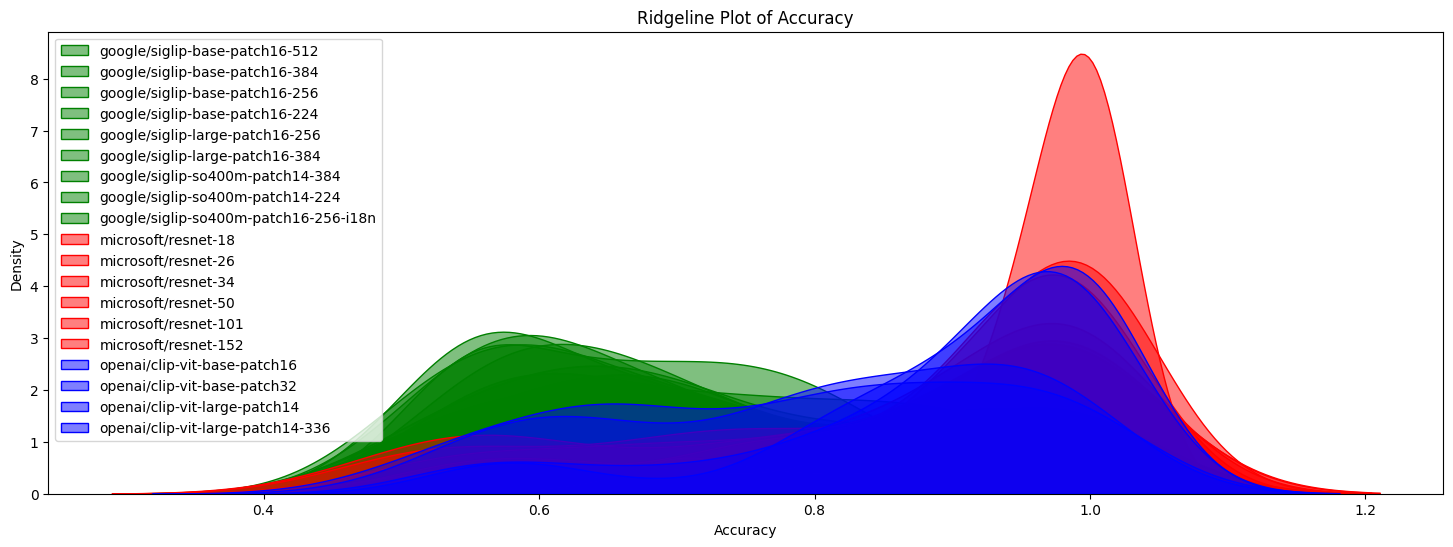

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Method names and corresponding colors
method_names = model_name_list
method_types = ['siglip' if 'siglip' in name else 'resnet' if 'resnet' in name else 'clip' for name in method_names]
colors = ['g' if 'siglip' in name else 'r' if 'resnet' in name else 'b' for name in method_names]

# Prepare data for ridgeline plot
num_methods = len(method_names)
x_data = [accuracy_array[:, i] for i in range(num_methods)]  # Separate data for each method
x_data = np.concatenate(x_data)  # Combine into a single array

# Reshape and repeat data to mimic long-form format
method_indices = np.repeat(np.arange(num_methods), accuracy_array.shape[0])  # Repeat method indices
method_names_repeated = np.tile(method_names, accuracy_array.shape[0])  # Repeat method names

# Create figure and axes
fig, ax = plt.subplots(figsize=(18, 6))

# Plot density curves
for i, method_name in enumerate(method_names):
    sns.kdeplot(x=x_data[method_indices == i], color=colors[i], fill=True, alpha=0.5, label=method_name, ax=ax)

# Customize plot
ax.set_xlabel("Accuracy")
ax.set_title("Ridgeline Plot of Accuracy")
ax.legend()
plt.show()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


[Text(0, 0, 'google/siglip-base-patch16-512'),
 Text(1, 0, 'google/siglip-base-patch16-384'),
 Text(2, 0, 'google/siglip-base-patch16-256'),
 Text(3, 0, 'google/siglip-base-patch16-224'),
 Text(4, 0, 'google/siglip-large-patch16-256'),
 Text(5, 0, 'google/siglip-large-patch16-384'),
 Text(6, 0, 'google/siglip-so400m-patch14-384'),
 Text(7, 0, 'google/siglip-so400m-patch14-224'),
 Text(8, 0, 'google/siglip-so400m-patch16-256-i18n'),
 Text(9, 0, 'microsoft/resnet-18'),
 Text(10, 0, 'microsoft/resnet-26'),
 Text(11, 0, 'microsoft/resnet-34'),
 Text(12, 0, 'microsoft/resnet-50'),
 Text(13, 0, 'microsoft/resnet-101'),
 Text(14, 0, 'microsoft/resnet-152'),
 Text(15, 0, 'openai/clip-vit-base-patch16'),
 Text(16, 0, 'openai/clip-vit-base-patch32'),
 Text(17, 0, 'openai/clip-vit-large-patch14'),
 Text(18, 0, 'openai/clip-vit-large-patch14-336')]

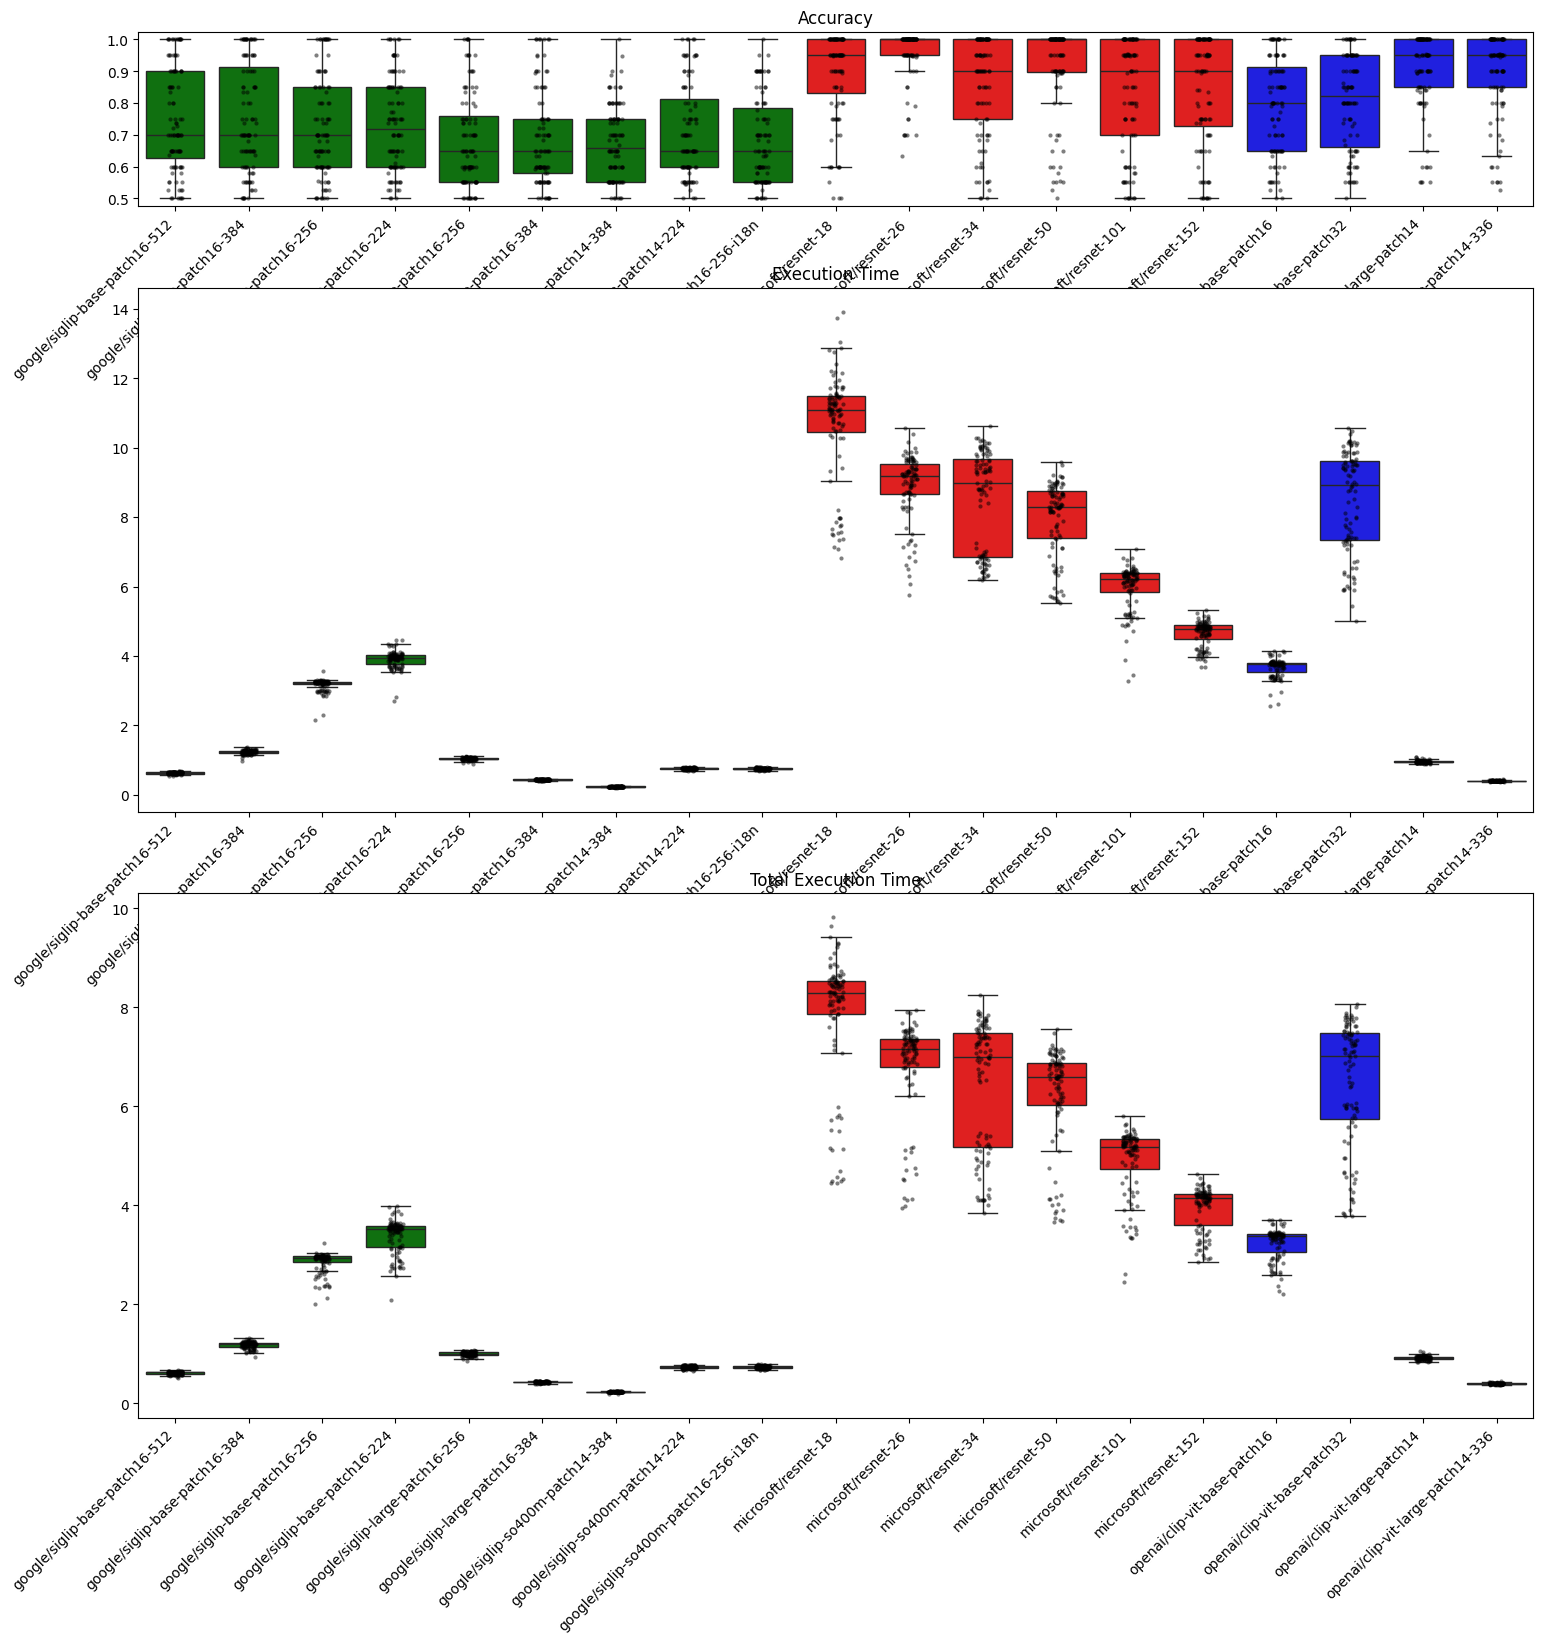

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure and axes for the plots
fig, axes = plt.subplots(3, 1, figsize=(18, 18), gridspec_kw={'height_ratios': [1, 3, 3]})

# Method names and corresponding colors
method_names = model_name_list
method_types = ['siglip' if 'siglip' in name else 'resnet' if 'resnet' in name else 'clip' for name in method_names]
colors = ['g' if 'siglip' in name else 'r' if 'resnet' in name else 'b' for name in method_names]

# --- Accuracy ---
# Boxplot with jitter
sns.boxplot(data=accuracy_array, ax=axes[0], palette=colors, showfliers=False)  # showfliers=False to hide outliers
sns.stripplot(data=accuracy_array, ax=axes[0], jitter=True, color='black', size=3, alpha=0.5)  # Add jitter points
# Violin plot
# sns.violinplot(data=accuracy_array, ax=axes[0], palette=colors, inner="quartile") # showfliers=False to hide outliers

axes[0].set_title('Accuracy')
axes[0].set_xticklabels(method_names, rotation=45, ha='right')


# --- Execution Time ---
# Boxplot with jitter
sns.boxplot(data=1/exec_time_array, ax=axes[1], palette=colors, showfliers=False)
sns.stripplot(data=1/exec_time_array, ax=axes[1], jitter=True, color='black', size=3, alpha=0.5)
# Violin plot
# sns.violinplot(data=1/exec_time_array, ax=axes[1], palette=colors, inner="quartile") # showfliers=False to hide outliers

axes[1].set_title('Execution Time')
axes[1].set_xticklabels(method_names, rotation=45, ha='right')


# --- Total Execution Time ---
# Boxplot with jitter
sns.boxplot(data=1/total_exec_time_array, ax=axes[2], palette=colors, showfliers=False)
sns.stripplot(data=1/total_exec_time_array, ax=axes[2], jitter=True, color='black', size=3, alpha=0.5)
# Violin plot
# sns.violinplot(data=1/total_exec_time_array, ax=axes[2], palette=colors, inner="quartile") # showfliers=False to hide outliers


axes[2].set_title('Total Execution Time')
axes[2].set_xticklabels(method_names, rotation=45, ha='right')

# ... (rest of your code for calculating and plotting means) ...

In [19]:
mean_total_exec_time_array = np.mean(total_exec_time_array, axis=0)
mean_total_exec_time_array_fps = 1/mean_total_exec_time_array

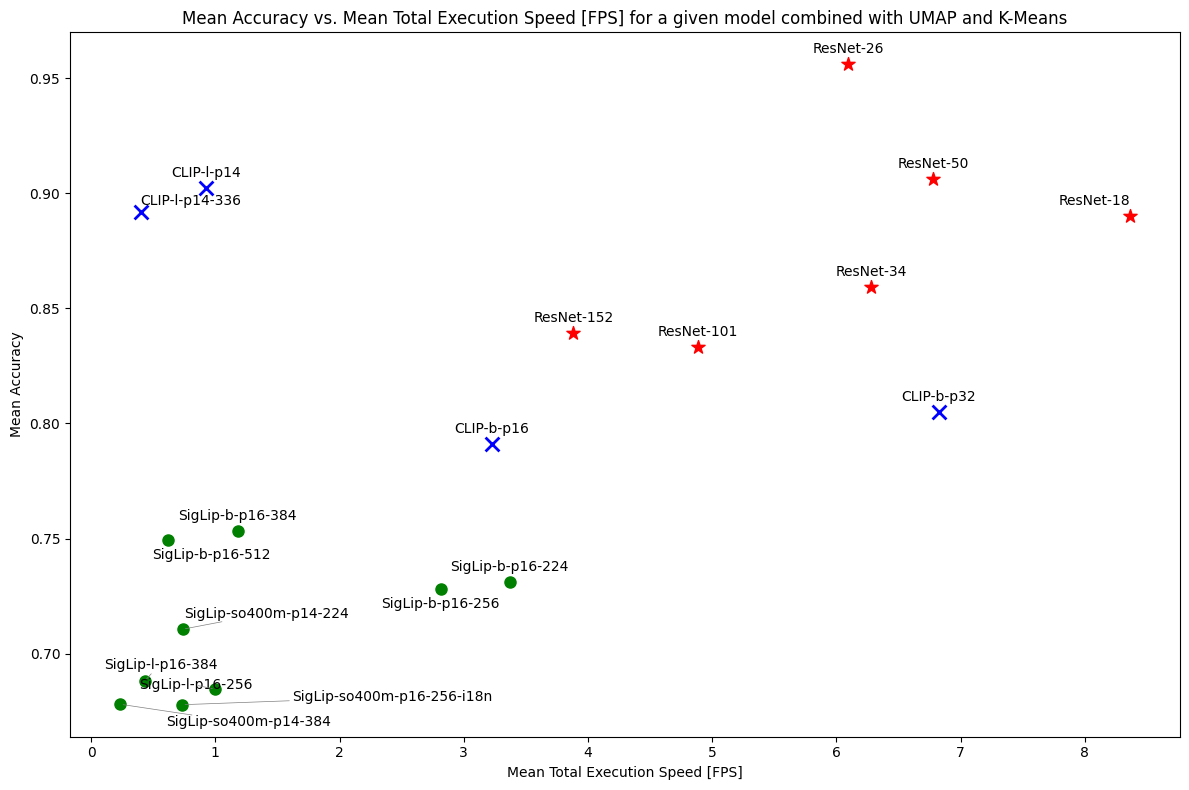

In [40]:

import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Calculate mean accuracy for each model
mean_accuracy_array = np.mean(accuracy_array, axis=0)

# Define color and marker mapping
method_names = model_name_list
method_names = [name.split('/')[-1] for name in method_names] # remove everything before the forward slash
method_names = [name.replace('base', 'b').replace('large', 'l').replace('resnet', 'ResNet').replace('siglip', 'SigLip').replace('clip', 'CLIP').replace('patch', 'p').replace('-vit', '') for name in method_names] # rename the parts of the names

method_types = ['SigLip' if 'SigLip' in name else 'ResNet' if 'ResNet' in name else 'CLIP' for name in method_names]
colors = ['g' if 'SigLip' in name else 'r' if 'ResNet' in name else 'b' for name in method_names]
markers = ['o' if 'SigLip' in name else '*' if 'ResNet' in name else 'x' for name in method_names]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

for i in range(len(method_names)):
    markersize = 8 if markers[i] == 'o' else 10  # Smaller circles
    linewidth = 2 if markers[i] == 'x' else 1  # Thicker crosses
    ax.scatter(mean_total_exec_time_array_fps[i], mean_accuracy_array[i],
               color=colors[i], marker=markers[i], label=method_names[i],
               s=markersize**2, linewidth=linewidth)  # s=markersize**2 for area scaling

# Use adjust_text to prevent label overlap
texts = []
siglip_crowded = []
for i, txt in enumerate(method_names):
    if 'SigLip' in txt and 'SigLip-b' not in txt:
      siglip_crowded.append(ax.text(mean_total_exec_time_array_fps[i], mean_accuracy_array[i], txt))
    else:
      texts.append(ax.text(mean_total_exec_time_array_fps[i], mean_accuracy_array[i], txt))

adjust_text(texts,
            expand_points=(2, 2),  # Increase space around points
            autoalign='y', # Align vertically
            only_move={'points':'y', 'texts':'y'}, # Only move in y direction
            )
adjust_text(siglip_crowded,
            expand_points=(2, 2),  # Increase space around points
            arrowprops=dict(arrowstyle="-", color='gray', lw=0.5), # Add gray arrows
            autoalign='y', # Align vertically
            only_move={'points':'y', 'texts':'y'}, # Only move in y direction
            )

# Set plot labels and title
ax.set_xlabel('Mean Total Execution Speed [FPS]')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Mean Accuracy vs. Mean Total Execution Speed [FPS] for a given model combined with UMAP and K-Means')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Evaluation

In [27]:
all_experiments_for_all_iterations=[]
NUM_ITERATIONS = 50
NUM_ITERATIONS_ARRAY = range(NUM_ITERATIONS)
for it in NUM_ITERATIONS_ARRAY:
  all_experiments_for_all_iterations.append(load_results_from_google_drive(it, is_iteration=True))

# Settings
show_plot_for_each_exp = True
show_percentage_differences = True
show_percentage_differences_text = True

accuracy_diff_list = []
exec_time_diff_list = []
total_exec_time_diff_list = []
model_name_list = []

for i_exp in range(len(all_experiments_for_all_iterations[0])): # for experiment, every batch has the same amount of methods in it
  mean_results_list = []
  mean_exec_time_list = []
  mean_total_exec_time_list = []
  for i_batch in range(len(all_experiments_for_all_iterations)): # for iteration
    current_exp = all_experiments_for_all_iterations[i_batch][i_exp]
    mean_results_list.append(np.mean(current_exp.results_list))
    mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
    mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

  if show_plot_for_each_exp:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
    ax1.plot(NUM_ITERATIONS_ARRAY, mean_results_list, label="Mean Accuracy")
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Mean Accuracy')
    ax1.legend()

    ax2.plot(NUM_ITERATIONS_ARRAY, mean_exec_time_list, label="Mean Exec time")
    ax2.plot(NUM_ITERATIONS_ARRAY, mean_total_exec_time_list, label="Mean Total Exec time")
    ax2.set_xlabel('Batch Size')
    ax2.set_ylabel('Mean Execution Time')
    ax2.legend()

    fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
    plt.show()

  if show_percentage_differences:
    mean_results_list = np.array(mean_results_list)
    mean_exec_time_list = np.array(mean_exec_time_list)
    mean_total_exec_time_list = np.array(mean_total_exec_time_list)

    accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
    exec_time_diff = ((np.max(mean_exec_time_list) - np.min(mean_exec_time_list)) / np.max(mean_exec_time_list)) * 100
    total_exec_time_diff = ((np.max(mean_total_exec_time_list) - np.min(mean_total_exec_time_list)) / np.max(mean_total_exec_time_list)) * 100
    # exec_time_diff = ((mean_exec_time_list[0] - mean_exec_time_list[-1]) / mean_exec_time_list[0]) * 100
    # total_exec_time_diff = ((mean_total_exec_time_list[0] - mean_total_exec_time_list[-1]) / mean_total_exec_time_list[0]) * 100

    accuracy_diff_list.append(accuracy_diff)
    exec_time_diff_list.append(exec_time_diff)
    total_exec_time_diff_list.append(total_exec_time_diff)
    model_name_list.append(current_exp.model_path)
    if show_percentage_differences_text:
      print(current_exp.model_path)
      print("Accuracy difference: ", accuracy_diff)
      print("Execution time difference: ", exec_time_diff)
      print("Total execution time difference: ", total_exec_time_diff)

if show_percentage_differences:
  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
  ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Accuracy Difference (%)")
  ax.set_title("Maximal accuracy difference across different models and batch sizes")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements


  fig, ax = plt.subplots(figsize=(15, 6))
  ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
  ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
  ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
  ax.set_xlabel("Model Name")
  ax.set_ylabel("Relative Time Difference (%)")
  ax.set_title("Relative time difference between batch size of 1 and 32 across different models")
  ax.legend()
  plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
  plt.tight_layout()  # Adjust layout to prevent overlapping elements



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/0_teams-clustering/experiments_list_batch32_it3.pkl'

# Ablation study on influence of batch size on the results

In [ ]:
# Partially repeated code...
# could most likely pack this into seperate function, keeping it like this to make sure the results are reproducible,
# don't want unexpected effect, that I didn't observe during my initial evaluation.
if DO_ABLATION_STUDY:
  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")

  for batch_size in BATCH_SIZE_ARRAY:
    for k, exp in enumerate(experiments_list):
      print("Model:", exp.model_path)
      print("Batch size:", batch_size)
      exp.init_model_n_processor()
      for i, image_path in tqdm(enumerate(jpg_files), desc='per image', total=len(jpg_files)):
          image = cv2.imread(str(image_path))
          players_crops = [sv.crop_image(image, xyxy) for xyxy in detections_list[i].xyxy]
          pillow_crops = [sv.cv2_to_pillow(crop) for crop in players_crops]
          batches = chunked(pillow_crops, batch_size)

          data = []
          start_time = time.perf_counter()
          for batch in batches:
            data.append(exp.forward(batch))
          end_time = time.perf_counter()
          exp.execution_time_list.append(end_time - start_time)

          data = np.concatenate(data)
          projections = Umap_reducer.fit_transform(data)
          clusters = np.array(KMeans_model.fit_predict(projections))

          total_time = time.perf_counter()
          exp.total_execution_time_list.append(total_time - start_time)

          result, clusters = get_best_results_n_clusters(clusters.astype(bool), detections_list[i].class_id.astype(bool))
          exp.results_list.append(result.sum() / len(clusters))
          exp.clusters_list.append(clusters)
      exp.clean_up()
      experiments_list[k] = exp

      print("Mean: ", np.mean(exp.results_list))
      print("Mean execution time: ", np.mean(exp.execution_time_list))
      print("FPS: ", 1/np.mean(exp.execution_time_list))
      print(exp.results_list)
      print("\n")

    save_results_to_google_drive(experiments_list, batch_size)

In [ ]:
if DO_ABLATION_STUDY:
  all_experiments_for_all_batches=[]
  for batch_size in BATCH_SIZE_ARRAY:
    all_experiments_for_all_batches.append(load_results_from_google_drive(batch_size))

  # Settings
  show_plot_for_each_exp = True
  show_percentage_differences = True
  show_percentage_differences_text = True

  accuracy_diff_list = []
  exec_time_diff_list = []
  total_exec_time_diff_list = []
  model_name_list = []

  for i_exp in range(len(all_experiments_for_all_batches[0])): # for experiment, every batch has so many methods in it
    mean_results_list = []
    mean_exec_time_list = []
    mean_total_exec_time_list = []
    for i_batch in range(len(all_experiments_for_all_batches)): # for batch size
      current_exp = all_experiments_for_all_batches[i_batch][i_exp]
      mean_results_list.append(np.mean(current_exp.results_list))
      mean_exec_time_list.append(np.mean(current_exp.execution_time_list))
      mean_total_exec_time_list.append(np.mean(current_exp.total_execution_time_list))

    if show_plot_for_each_exp:
      fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
      ax1.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_results_list), label="Mean Accuracy")
      ax1.set_xlabel('Batch Size')
      ax1.set_ylabel('Mean Accuracy')
      ax1.legend()

      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_exec_time_list), label="Mean Exec time")
      ax2.plot(np.array(BATCH_SIZE_ARRAY), np.array(mean_total_exec_time_list), label="Mean Total Exec time")
      ax2.set_xlabel('Batch Size')
      ax2.set_ylabel('Mean Execution Time')
      ax2.legend()

      fig.suptitle("Influence of Batch Size on Performance for " + current_exp.model_path, fontsize=16)
      plt.show()

    if show_percentage_differences:
      mean_results_list = np.array(mean_results_list)
      mean_exec_time_list = np.array(mean_exec_time_list)
      mean_total_exec_time_list = np.array(mean_total_exec_time_list)

      accuracy_diff = ((np.max(mean_results_list) - np.min(mean_results_list)) / np.max(mean_results_list)) * 100
      exec_time_diff = ((mean_exec_time_list[0] - mean_exec_time_list[-1]) / mean_exec_time_list[0]) * 100
      total_exec_time_diff = ((mean_total_exec_time_list[0] - mean_total_exec_time_list[-1]) / mean_total_exec_time_list[0]) * 100

      accuracy_diff_list.append(accuracy_diff)
      exec_time_diff_list.append(exec_time_diff)
      total_exec_time_diff_list.append(total_exec_time_diff)
      model_name_list.append(current_exp.model_path)
      if show_percentage_differences_text:
        print(current_exp.model_path)
        print("Accuracy difference: ", accuracy_diff)
        print("Execution time difference: ", exec_time_diff)
        print("Total execution time difference: ", total_exec_time_diff)

  if show_percentage_differences:
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, accuracy_diff_list, label="Accuracy Difference (%)", marker='o')
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Accuracy Difference (%)")
    ax.set_title("Maximal accuracy difference across different models and batch sizes")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements


    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(model_name_list, exec_time_diff_list, label="Execution Time Difference (%)", marker='s')
    ax.plot(model_name_list, total_exec_time_diff_list, label="Total Execution Time Difference (%)", marker='^')
    ax.axhline(y=0, color='gray', linestyle='--', label="Zero Difference") # Line at y=0
    ax.set_xlabel("Model Name")
    ax.set_ylabel("Relative Time Difference (%)")
    ax.set_title("Relative time difference between batch size of 1 and 32 across different models")
    ax.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlapping elements
